# Telco-churn-classification-project

## Project Goals

* The goal of this project is to identify the attributes of customers churn rate in Telco company in order to make recommendations of how to reduce churan rate for Telco company.


## Initial Questions

1. Is the churn rate effected by monthly charges?

2. Is the churn rate effected by providers?

3. Does churn rate related to tenure?

4. Does the churn rate related to the additional services?

5. Does the churn rate effeted by partner and dependent?

6. Does the churn rate effeted by contract type?

## Data Dictionary

Variables are used in this analyst: 

* churn
* monthly charges
* tenure
* contract types: month-to-month, one-year, two-year
* additional services: online security, online backup, tech support, streaming tv, streaming movies
* contract type: month-to-month, one-year, two-year
* partners and dependents number

## Wrangle Titanic Data
#### To acquire the telco churn data, I used the telco_churn in our mySQL server Then selected all columns from the customers table and left join internet_service_types, payment_types and contract_types tables.

* select * from customers left join internet_service_types using(internet_service_type_id) left join payment_types using (payment_type_id) left join contract_types using (contract_type_id)

In [1]:
# Acquire telco_churn data from MySql database 
import acquire_telco

# Make the commection to the database and run the query. Then we will get the data we need.
df = acquire_telco.new_telco_data()

#### To clean the data, I did the following:
    
1. Convert data type: convert total_charges from object to float.
2. Drop rows: There are 11 missing data for total_charges, since it's a very small portion, so I just dropped those 11 rows.
3. Drop coolumns: Since I already added internet_service_types, payment_types and contract_types into my data, so I dropped payment_type_id, internet_service_type_id znd contract_type_id columns.
4. Encode binary categorical variables into numeric values: gender, partner, dependents, phone_service, paperless_billing, churn, online_security, online_backup.
5. Get dummies for non-binary categorical variables: multiple_lines, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies, contract_type, internet_service_type, payment_type.
6. Creat new columns: number_relationships, number_online_services, yearly_tenure, has_internet, additional_services

In [2]:
import pandas as pd
import prepare_telco

train, validate, test = prepare_telco.prep_telco_data(df)

* Our data is now split into 3 samples so that we can use the train sample to explore, fit to models and evaluate without looking at new data.
* The validate is used to verify that our models built are not overfit to the train dataset.
* The test set is used to give an estimate of how this model will perform on data is has never seen in the future.

## Set the Data Context

<AxesSubplot:xlabel='churn', ylabel='Count'>

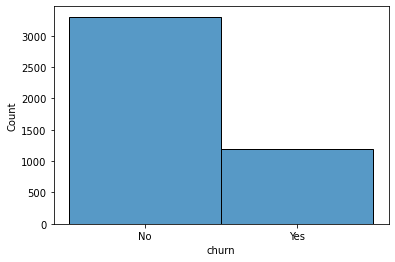

In [17]:
# Overall churn rate on train set
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.histplot(train.churn)

In [20]:
train.shape

(4500, 55)

In [5]:
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

<AxesSubplot:xlabel='internet_service_type', ylabel='Count'>

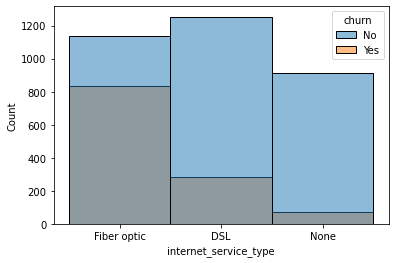

In [12]:
sns.histplot(data = train, x = 'internet_service_type', hue = 'churn')

In [18]:
pd.crosstab(train.internet_service_type, train.churn, normalize = 'index')

churn,No,Yes
internet_service_type,,
DSL,0.814286,0.185714
Fiber optic,0.575558,0.424442
None,0.926113,0.073887


<AxesSubplot:xlabel='contract_type', ylabel='Count'>

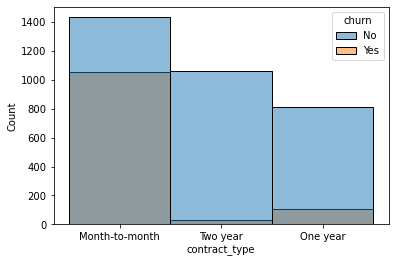

In [16]:
sns.histplot(data = train, x = 'contract_type', hue = 'churn')

In [19]:
pd.crosstab(train.contract_type, train.churn, normalize = 'index')

churn,No,Yes
contract_type,,
Month-to-month,0.575271,0.424729
One year,0.883442,0.116558
Two year,0.971586,0.028414


# Exploratory Analysis: Who was more likely to churn?

## Question 1. Is the churn rate effected by monthly charges?

In [21]:
# mean of monthly charges for customers who churn vs who don't churn?

train.groupby('churn').monthly_charges.mean()

churn
No     61.131613
Yes    74.652048
Name: monthly_charges, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='monthly_charges'>

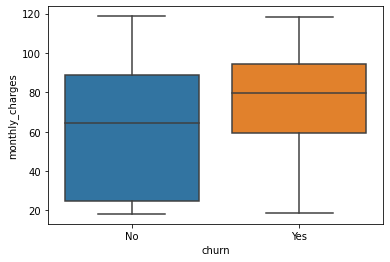

In [22]:
sns.boxplot(data = train, y = 'monthly_charges', x = 'churn')

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

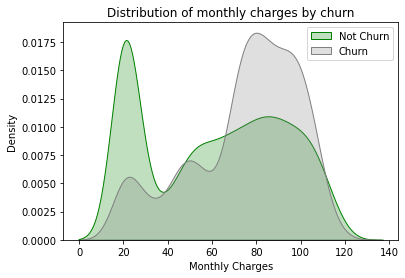

In [23]:
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'No') ],
                color="green", shade = True)
ax = sns.kdeplot(train.monthly_charges[(train["churn"] == 'Yes') ],
                ax =ax, color="grey", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')

### statistical test ---- t-test (2 sample 1-tailed test)

I believe customers who churn are charged more (monthly average) than customers who don't churn.

Is the mean of monthly charges of customers who churn significantly higher than the mean of those who don't churn?

<AxesSubplot:>

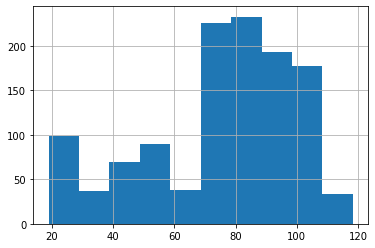

In [24]:
# histogram of churned customers
churn_sample = train[train.churn == 'Yes'].monthly_charges

churn_sample.hist()

<AxesSubplot:>

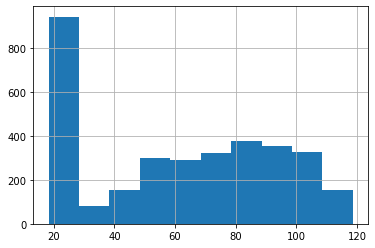

In [25]:
no_churn_sample = train[train.churn == 'No'].monthly_charges

no_churn_sample.hist()

* Set Hypothesis

H0: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who stay.

Ha: Mean of monthly charges of churned customers > Mean of monthly charges of customers who stay.

* set alpha

In [28]:
alpha = 0.05

* Verify Assumptions

1. Independent Samples. YES! no observations in the churn sample exist in the no-churn sample.

2. Normal Distribution, or at least 30 observations and "kinda" normal. The more observations you have, the less "normal" it needs to appear. (CLT). YES! Plenty of observations

3. Equal Variances (the scipy methods we will use has an argument to handle when variances aren't equal).

In [26]:
churn_sample.var(), no_churn_sample.var()

(610.5202363859298, 973.6230640332021)

In [29]:
import scipy.stats as stats

t, p = stats.ttest_ind(churn_sample,no_churn_sample, equal_var=False)

t, p/2, alpha

(15.067898021010361, 1.3606253087672313e-49, 0.05)

In [30]:
if (p/2 < alpha) & (t > 0):
    print("Reject null. The monthly charges for churn customers is higher than non-churn customers.")
else:
    print("Fail to reject null. The monthly charges for churn customers is equal or lower than non-churn customers.")

Reject null. The monthly charges for churn customers is higher than non-churn customers.


## Answer 1

Customers who have higher monthly charges are more likely to churn.

## Question 2. Does the churn rate related to tenure?

<AxesSubplot:xlabel='churn', ylabel='tenure'>

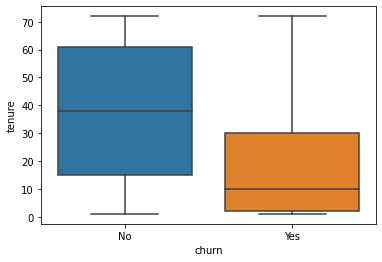

In [39]:
sns.boxplot(x = 'churn', y = 'tenure', data = train)

In [40]:
train.groupby('churn').tenure.mean()

churn
No     37.689770
Yes    18.061037
Name: tenure, dtype: float64

### T-test : 2 sample 1-teailed

I believe that the mean of tenure for churn customers is lower than non-churn customers.

* H0: Mean of tenure for churn customers >= non-churn customers.

* H1: Mean of tenure for churn customers < non-churn customers.

<AxesSubplot:>

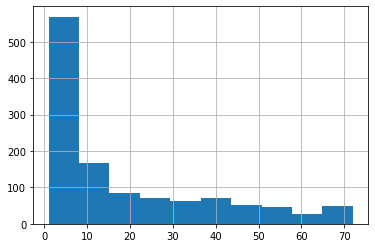

In [41]:
# histogram of churned customers
churn_sample_tenure = train[train.churn == 'Yes'].tenure

churn_sample_tenure.hist()

<AxesSubplot:>

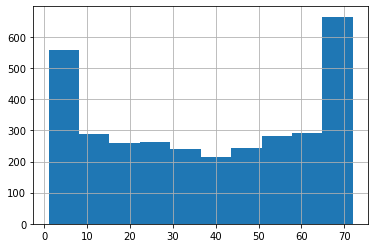

In [42]:
no_churn_sample_tenure = train[train.churn == 'No'].tenure

no_churn_sample_tenure.hist()

In [43]:
alpha = 0.05

In [44]:
churn_sample_tenure.var(), no_churn_sample_tenure.var()

(391.3711667902756, 583.9458111490103)

In [45]:
t1, p1 = stats.ttest_ind(churn_sample_tenure,no_churn_sample_tenure, equal_var=False)

t1, p1/2, alpha

(-27.649600939497784, 8.442633398747043e-148, 0.05)

In [46]:
if (p1/2 < alpha) & (t1 < 0):
    print("Reject null. Mean of tenure for churn customers is less then non-churn customers.")
else:
    print("Fail to reject null. ")

Reject null. Mean of tenure for churn customers is less then non-churn customers.


## Answer 2

The churn customers have lower tenure then non-churn customers.

## Question 3. Does the churn rate related to the additional services?

Additional services: 

    online security, online backup, tech support, streaming tv, streaming movies

<AxesSubplot:xlabel='additional_services', ylabel='count'>

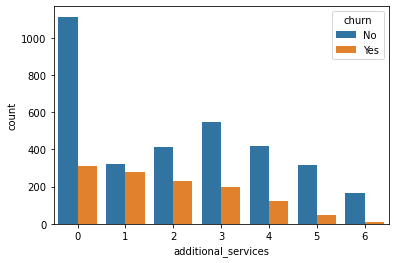

In [47]:
sns.countplot(x = 'additional_services', hue = 'churn', data = train)

## Answer 3

The more additional services use, the lower the churn rate is.

## Question 4. Does the churn rate effeted by contract type?

In [52]:
pd.crosstab(train.contract_type, train.churn, normalize = 'index')

churn,No,Yes
contract_type,,
Month-to-month,0.575271,0.424729
One year,0.883442,0.116558
Two year,0.971586,0.028414


<AxesSubplot:xlabel='contract_type', ylabel='count'>

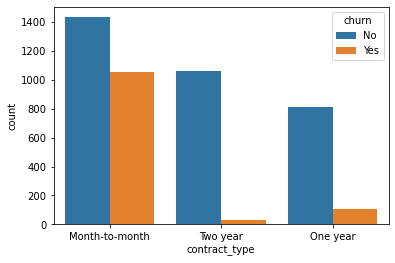

In [53]:
sns.countplot(x = 'contract_type', hue = 'churn', data = train)

## Answer 4

Month-to-month contract type has higher churn rate.

## Summary: 

1. Customers who have high monthly charges are more like to churn.
2. The churn customers have less tenure.
3. The more additional services use, the churn rate is lower.
4. Month-to-month contract type has higher churn rate.

#### Therefore, features I will use are: 
* monthly charges
* tenure
* addtional services
* contracts type.

# Predicting Churn

Because churn is a boolean/yes or no value, we will use classification machine learning algorithms to fit to our training data and we will evaluate on validate. We will pick the best model using accuracy because the data is mostly balanced, and the risk of an event happening balances the risk of getting a prediction wrong.

## Baseline

I will set a baseline prediction by predicting all passengers to not churn (churn == 0). I will evaluate the accuracy of that.

In [57]:
# baseline
train['baseline_churn'] = 0

baseline_churn_accuracy = (train.churn_encoded == train.baseline_churn).mean()

print(f'baseline accuracy on train set: {baseline_churn_accuracy:.2%}')

baseline accuracy on train set: 73.42%


## Fit 3 models

The top 3 models we built were the decision tree, KNN, and logistic regression. 

The models differed in the algorithms. 

The Logistic Regression performed the best at 79.67% accuracy as you will see.

In [58]:
x_train = train[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_train = train.churn_encoded

x_validate = validate[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_validate = validate.churn_encoded

x_test = test[['monthly_charges','contract_type_One year', 'contract_type_Two year', 'tenure', 'additional_services']]
y_test = test.churn_encoded

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

### Train

In [98]:
# Create the objects
# decision tree
tree = DecisionTreeClassifier(max_depth=6, random_state=123)

# KNN
knn = KNeighborsClassifier(n_neighbors=10)

# logistic regression
logit = LogisticRegression(C=1, random_state=123)

# fit on train
tree.fit(x_train, y_train)
knn.fit(x_train, y_train)
logit.fit(x_train, y_train)

# predict on train
y_pred_tree_train = tree.predict(x_train)
y_pred_knn_train = knn.predict(x_train)
y_pred_logistic_train = logit.predict(x_train)

# evaluate on train
print('Accuracy of decision tree (max_depth=6) classifier on train set: {:.2%}'
     .format(tree.score(x_train, y_train)))
print('Accuracy of KNN(k=10) classifier on train set: {:.2%}'
     .format(knn.score(x_train, y_train)))
print('Accuracy of Logistic Regression (c=1) on train set: {:.2%}'
     .format(logit.score(x_train, y_train)))

Accuracy of decision tree (max_depth=6) classifier on train set: 80.49%
Accuracy of KNN(k=10) classifier on train set: 81.51%
Accuracy of Logistic Regression (c=1) on train set: 79.49%


### Validate

In [94]:
# predict on validate
y_pred_tree_validate = tree.predict(x_validate)
y_pred_knn_validate = knn.predict(x_validate)
y_pred_logistic_validate = logit.predict(x_validate)

# evaluate on validate
print('Accuracy of decision tree classifier on validate set: {:.2%}'
     .format(tree.score(x_validate, y_validate)))
print('Accuracy of KNN(k=10) classifier on validate set: {:.2%}'
     .format(knn.score(x_validate, y_validate)))
print('Accuracy of Logistic Regression (c=1) on validate set: {:.2%}'
     .format(logit.score(x_validate, y_validate)))

Accuracy of decision tree classifier on validate set: 77.33%
Accuracy of KNN(k=10) classifier on validate set: 76.71%
Accuracy of Logistic Regression (c=1) on validate set: 77.60%


None of these model appear to be overfit. X model performed the best on the validate sample, therefore, I moved forward with that model.

### Test

In [100]:
# predict on test
y_pred_test = logit.predict(x_test)
y_pred_proba_test = logit.predict_proba(x_test)

# evaluate on test
print('Accuracy of Logistic Regression (c=1) on test set: {:.2%}'
     .format(logit.score(x_test, y_test)))

Accuracy of Logistic Regression (c=1) on test set: 79.67%


I expect this model to perform with 79.67% accuracy in the future on data it has not seen, given no major changes in our data source.

# Conclusion

## Summary

## Recommendations

## Next Steps